In [9]:
import os 
import json
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from torch.optim import lr_scheduler
import tqdm
import numpy as np
from matplotlib import pyplot as plt
# from matplotlib.nxutils import points_inside_poly
from make_imagenet_64_c import *
from torchattacks import FGSM, PGD
from collections import Counter
import math
%matplotlib inline


In [10]:
import sys
sys.path.insert(1, '../Mask_Data/MSCOCO-IC')
import dataloader

In [4]:
mscoco = dataloader.DataLoader(data_dir = '../Mask_Data/MSCOCO-IC/')

In [115]:
x_batch, xt_batch, y_batch = mscoco.get_batch(0, 25, mode='val', do_augment = False)

In [116]:
print(np.amax(xt_batch, axis=-1).shape)

(25, 32, 32)


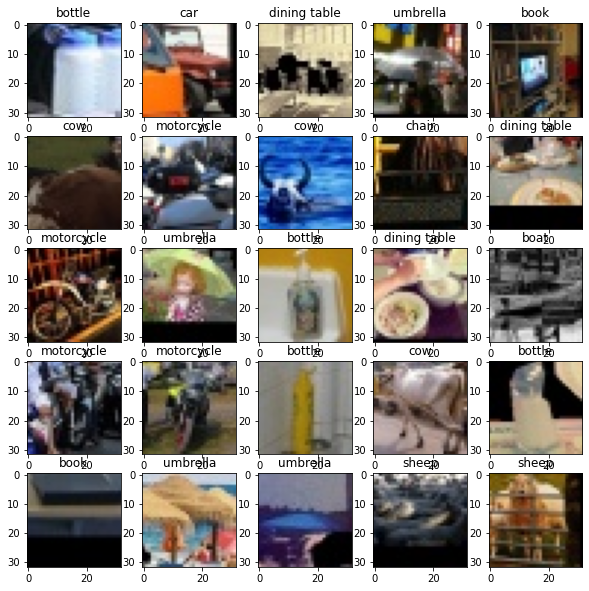

In [117]:
# print((np.amax(xt_batch, axis=-1) > 0).astype(np.int64))
plt.figure(figsize=(10,10))
for d_idx in range(25):
   ax = plt.subplot(5, 5, d_idx + 1)
   ax.title.set_text(mscoco.label_info[mscoco.rev_label_mapping[y_batch[d_idx]]])
   plt.imshow(x_batch[d_idx, :, :, ::-1].reshape(32, 32, 3))
# plt.savefig('/home/pratik18v/Desktop/temp.jpg')
plt.show()


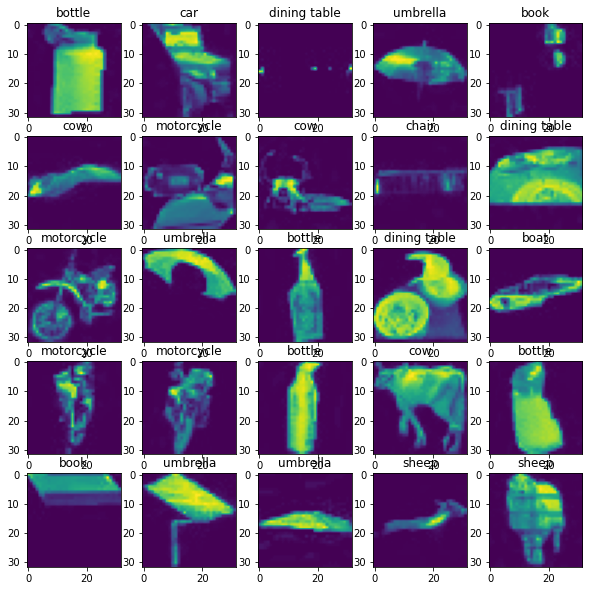

In [123]:
# print((np.amax(xt_batch, axis=-1) > 0).astype(np.int64))
plt.figure(figsize=(10,10))
for d_idx in range(25):
   ax = plt.subplot(5, 5, d_idx + 1)
   ax.title.set_text(mscoco.label_info[mscoco.rev_label_mapping[y_batch[d_idx]]])
   plt.imshow(xt_batch[d_idx, :, :, ::-1].reshape(32, 32, 3))
# plt.savefig('/home/pratik18v/Desktop/temp.jpg')
plt.show()


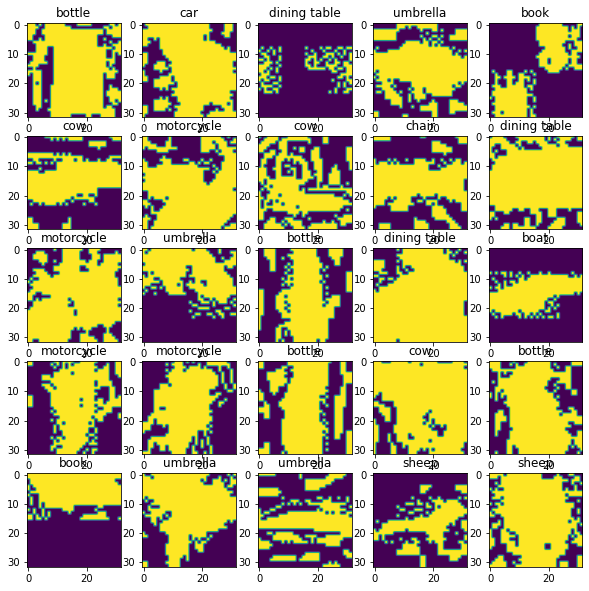

In [133]:
# print((np.amax(xt_batch, axis=-1) > 0).astype(np.int64))
plt.figure(figsize=(10,10))
for d_idx in range(25):
   ax = plt.subplot(5, 5, d_idx + 1)
   ax.title.set_text(mscoco.label_info[mscoco.rev_label_mapping[y_batch[d_idx]]])
   x = xt_batch[d_idx, :, :, 2]
#    x = x.mean(axis=2)
   x[x>0] =1  

   plt.imshow(x)#.reshape(32, 32, 3))
# plt.savefig('/home/pratik18v/Desktop/temp.jpg')
plt.show()


In [13]:
    #Printing out data statistics
    print("Number of classes: {}".format(len(mscoco.label_info)))
    print("Number of training samples: {}".format(mscoco.num_train))
    print("Number of validation samples: {}".format(mscoco.num_val))
    print("Training data label distribution:")
    print(Counter(mscoco.train_labels))
    print("Validation data label distribution:")
    print(Counter(mscoco.val_labels))

Number of classes: 10
Number of training samples: 43910
Number of validation samples: 21620
Training data label distribution:
Counter({4: 4391, 2: 4391, 0: 4391, 9: 4391, 3: 4391, 1: 4391, 5: 4391, 7: 4391, 6: 4391, 8: 4391})
Validation data label distribution:
Counter({0: 2162, 6: 2162, 9: 2162, 4: 2162, 3: 2162, 2: 2162, 1: 2162, 7: 2162, 5: 2162, 8: 2162})


In [14]:
xt_batch.max()

1.0

# Training the models

In [24]:
ds_trans = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])

# d_mean = [0.485, 0.456, 0.406]
# d_var = [0.229, 0.224, 0.225]


In [25]:
kind = 'box'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/coco_'+kind+'.pth', map_location=torch.device('cpu')))


In [26]:
# iter(next(train_dataloader))

In [27]:
def train_model(net, criterior, optimizer, num_epochs, save_path):

    # device GPU or CPU?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device 
    net.to(device)
    net.train()
    # boost network speed on gpu
    torch.backends.cudnn.benchmark = True

    phase = 'train'

    batch_size = 1
    num_batches = 10000 #int(math.ceil(mscoco.num_train/batch_size))
#     import pdb; pdb.set_trace()

    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch+1, num_epochs))

        epoch_loss = 0.0
        epoch_corrects = 0


        for ibatch in range(num_batches):
            bstart = ibatch * batch_size
            bend = min(bstart + batch_size, mscoco.num_train)

            x_batch, _, y_batch =\
              mscoco.get_batch(bstart, bend, mode='train')
#             x_batch = (x_batch - d_mean)/d_var
#             import pdb; pdb.set_trace()
            x_batch = x_batch.astype('uint8')
            x_batch = Image.fromarray(x_batch[0])

            inputs = ds_trans(x_batch)[None]            
            labels = torch.tensor(y_batch)
#             inputs = inputs.permute(0,3,1,2)
            optimizer.zero_grad()
#             import pdb; pdb.set_trace()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = net(inputs)
                #labels = labels
                loss = criterior(outputs, labels)
                _, preds = torch.max(outputs, axis=1)

                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * inputs.shape[0]
                epoch_corrects += torch.sum(preds==labels.data)


        epoch_loss = epoch_loss / (num_batches * batch_size)
        epoch_accuracy = epoch_corrects.double() / (num_batches * batch_size)

        print("{} Loss: {:.4f}, Acc: {:.4f}".format(phase, epoch_loss, epoch_accuracy))

    torch.save(net.state_dict(), save_path)

In [28]:
# torch.save(resnet.state_dict(), './models/coco_box.pth')

In [ ]:
train_model(resnet, criterion, optimizer, 15, './models/coco_box.pth')

device: cpu
Epoch 1/15


In [ ]:
# for u,v in dataloader_dict['train']:
#     print(u)

In [ ]:
torch.zeros((10,10))

In [ ]:
def test_model_clean(net):
    correct = 0
    total = 0

    # device GPU or CPU?
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device 
    net.to(device)
    net.eval()
    
    
    batch_size = 1
#     num_batches = int(math.ceil(mscoco.num_val/batch_size))
    num_batches = 100


    for ibatch in range(num_batches):
        bstart = ibatch * batch_size
        bend = min(bstart + batch_size, mscoco.num_val)

        a, b, y_batch = mscoco.get_batch(bstart, bend, mode='val')
        x_batch = a if kind == 'box' else b

        #import pdb; pdb.set_trace()
        x_batch = x_batch.astype('uint8')
        x_batch = Image.fromarray(x_batch[0])
        
        inputs = ds_trans(x_batch)[None]            
        labels = torch.tensor(y_batch)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
    #     correct += (predicted == labels.cuda()).sum()
        correct += (predicted == labels).sum()
    
#     import pdb; pdb.set_trace()
    acc = float(correct) / total
        
    return acc#, images    

In [ ]:
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/coco_box.pth'))

In [ ]:
# load_path
# load_model(resnet, load_path)
test_model_clean(resnet)

# Distortion analysis

In [ ]:
import collections

print('\nUsing ObjectNet data')

distortions = [
#     'gaussian_noise', 
#     'shot_noise', 
#     'impulse_noise',
#     'defocus_blur',   
#     'glass_blur', 
    'motion_blur', 
#     'zoom_blur',
#     'snow', 
#     'frost', 
#     'fog', 
#     'brightness',
#     'contrast', 
#     'elastic_transform', 
#     # 'pixelate', 
#     'jpeg_compression',
    # 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate'
]
transform = transforms.Compose([
#         transforms.CenterCrop(224),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])

In [ ]:
kind = 'box'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/coco_'+kind+'.pth'))

In [ ]:
device = 'cpu'
resnet.eval()
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
error_rates = dict()
for distortion in distortions:
  print(distortion + '\n')
  error_rates[distortion] = [] 
#     error_rates_distortion = dict() 
  
  for severity in [5]: #range(1,4):
        print(str(severity))        
        #         error_rates_distortion[severity] = []

        res_top1, res_top5 = [], []
        correct = 0
        total = 0


        batch_size = 1
        num_batches = 100

        for ibatch in range(num_batches):
          bstart = ibatch * batch_size
          bend = min(bstart + batch_size, mscoco.num_train)
 
          x_batch, _, y_batch =\
          mscoco.get_batch(bstart, bend, mode='train')

          x_batch = x_batch.astype('uint8')
          print(x_batch.shape)
          x_batch = Image.fromarray(x_batch[0])
          images = x_batch.resize((224, 224))
          label = torch.tensor(y_batch)
            
#           import pdb; pdb.set_trace()            
#           images = images.permute(1,2,0)  
          exr = distortion + '(images,severity)'
#           import pdb; pdb.set_trace()
          aa = eval(exr).astype('uint8')
          print(aa.shape)
          if len(aa.shape) < 3: continue
          aa = Image.fromarray(aa)
#           aa = aa.permute(1,2,0)
          images = ds_trans(aa) 
#           images = transform((aa).numpy()) # range [0,1]

#           import pdb; pdb.set_trace()    
          outputs = resnet(images[None])
          _, predicted = torch.max(outputs.data, 1)

          total += 1#label.size(0)
        #     correct += (predicted == labels.cuda()).sum()
          correct += (predicted == label).sum()

        acc = float(correct) / total

        # after severity
          
        error_rates[distortion].append(acc)    
  print(error_rates[distortion])

# 

In [ ]:

#BOX
box_res =  np.array([[]])


#Seg
seg_res =  np.array([[]])

In [ ]:
fig = plt.figure(figsize=[3.5, 4.5])
plt.plot(np.mean(box_res, axis=0)*100, color='r', marker= 'o', linewidth=2, markersize= 8)
plt.plot(np.mean(seg_res, axis=0)*100, color='black', marker= '^', linewidth=2, markersize= 8)
plt.legend([ 'Bounding Box', 'Seg. Mask'])
plt.xlabel('severity')
plt.ylabel('accuracy')
plt.xticks([ 0, 1, 2, 3], [ 1, 2, 3, 4])    

# Adversarial perturbation analysis

In [10]:
ds_trans = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])


In [59]:
# del resnet
# del resnet_copy

kind = 'box'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/coco_'+kind+'.pth', map_location=torch.device('cpu')))


resnet_copy = models.resnet18(pretrained=True)
num_ftrs = resnet_copy.fc.in_features
resnet_copy.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet_copy.load_state_dict(torch.load('./models/coco_'+kind+'.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [63]:
for xx in [2,8,16]:
    eps = xx/255
    print(eps)

    for attack in [FGSM(resnet_copy, eps=eps), PGD(resnet_copy, eps=eps, alpha=8/255, iters=5)]:
    #     attack = FGSM(resnet_copy, eps=eps)
        # attack = PGD(resnet_copy, eps=eps, alpha=8/255, iters=5)      
        print(attack) 
        
        correct = 0
        total = 0

        resnet.eval()

        # resnet.train(False)
        apply_mask = False
        batch_size = 20
        num_batches = 1000

        for ibatch in range(num_batches):
            # just use the first sample in batch bc of a funcky issue with the dataloader
            bstart = ibatch * batch_size
            bend = min(bstart + batch_size, mscoco.num_val)

            a, b, y_batch = mscoco.get_batch(bstart, bend, mode='val')
            x_batch = a if kind == 'box' else b

        #     plt.imshow(x_batch[0, :, :, ::-1].reshape(32, 32, 3)); plt.show()


        #     import pdb; pdb.set_trace()
            x_batch = x_batch[0, :, :, ::-1]#[None]
            x_batch = (x_batch*255).astype('uint8')
        #     print(x_batch.shape)
        #     import pdb; pdb.set_trace()

            if apply_mask:
                mask = np.array(x_batch)
                mask[mask>0] = 1
                mask = mask.mean(axis=2)
                mask[mask<1] = 0

                mask = Image.fromarray(mask)
                mask = mask.resize((224, 224))
                mask = np.array(mask)
        #     mask =  mask[:,:,0] #mask.mean(axis=2) # mask[:,:,0] #



            x_batch = Image.fromarray(x_batch)
        #     import pdb; pdb.set_trace()

        #     images = x_batch.resize((224, 224))
            label = torch.tensor(y_batch[0])

            image = ds_trans(x_batch)

        #     import pdb; pdb.set_trace()
        #     image = image.unsqueeze(0)

        #     import pdb; pdb.set_trace()
            imin = image.min() 
            imax = image.max()     
            image = (image - imin) / (imax - imin)
            inputs_adv = attack(image.detach()[None], torch.tensor([label]))
            inputs_adv = inputs_adv * (imax  - imin) + imin

            if apply_mask:
                 inputs_adv[0,0] = inputs_adv[0,0]*mask
                 inputs_adv[0,1] = inputs_adv[0,1]*mask
                 inputs_adv[0,2] = inputs_adv[0,2]*mask


        #     inputs_adv = (inputs_adv[0].permute(1,2,0)*255).numpy().astype('uint8')
        # #     import pdb; pdb.set_trace()
        #     inputs_adv = Image.fromarray(inputs_adv) 
        #     inputs_adv = ds_trans(inputs_adv)    
        #     import pdb; pdb.set_trace()    
        #     with torch.no_grad():        
            with torch.set_grad_enabled(False):
                  output = resnet(inputs_adv) #[None])
#                 output = resnet(image[None])        

            #         outputs = net(images)
            _, predicted = torch.max(output.data, 1)

            total += 1 #label.size(0)
            #     correct += (predicted == labels.cuda()).sum()
            correct += (predicted == label).sum()

            acc = float(correct) / total
        print(acc)

0.00784313725490196
FGSM(model_name=ResNet, training=True, device=cpu, mode=float, eps=0.00784313725490196)
0.265
PGD(model_name=ResNet, training=True, device=cpu, mode=float, eps=0.00784313725490196, alpha=0.03137254901960784, iters=5)
0.313
0.03137254901960784
FGSM(model_name=ResNet, training=True, device=cpu, mode=float, eps=0.03137254901960784)
0.129
PGD(model_name=ResNet, training=True, device=cpu, mode=float, eps=0.03137254901960784, alpha=0.03137254901960784, iters=5)
0.094
0.06274509803921569
FGSM(model_name=ResNet, training=True, device=cpu, mode=float, eps=0.06274509803921569)
0.141
PGD(model_name=ResNet, training=True, device=cpu, mode=float, eps=0.06274509803921569, alpha=0.03137254901960784, iters=5)
0.003


In [58]:
kind

'seg'

In [85]:
mask.shape

(224, 224)

In [79]:
mask[mask>0] = 0



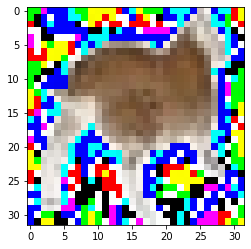

In [88]:
plt.imshow(x_batch); plt.show()

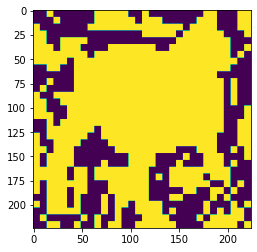

In [86]:
plt.imshow(mask*255); plt.show()

0.03137254901960784
FGSM(model_name=ResNet, training=True, device=cpu, mode=float, eps=0.03137254901960784)
> <ipython-input-184-59162a87bd64>(125)<module>()->None
-> with torch.set_grad_enabled(False):


(Pdb)  plt.imshow(inputs_adv[0].permute(1,2,0)); plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


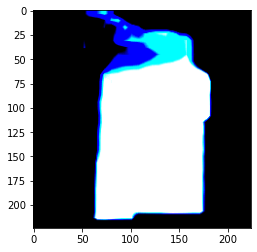

(Pdb)  plt.imshow(inputs_adv[0,0]); plt.show()


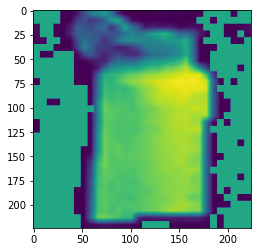

(Pdb)  q


BdbQuit: 

In [184]:
# del resnet
# del resnet_copy


kind = 'seg'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/coco_'+kind+'.pth', map_location=torch.device('cpu')))


resnet_copy = models.resnet18(pretrained=True)
num_ftrs = resnet_copy.fc.in_features
resnet_copy.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet_copy.load_state_dict(torch.load('./models/coco_'+kind+'.pth', map_location=torch.device('cpu')))



for xx in [8]:
    eps = xx/255
    print(eps)

    for attack in [FGSM(resnet_copy, eps=eps), PGD(resnet_copy, eps=eps, alpha=8/255, iters=5)]:
    #     attack = FGSM(resnet_copy, eps=eps)
        # attack = PGD(resnet_copy, eps=eps, alpha=8/255, iters=5)      
        print(attack) 
        
        correct = 0
        total = 0

        resnet.eval()

        # resnet.train(False)
        apply_mask = True
        batch_size = 20
        num_batches = 100#00

        for ibatch in range(num_batches):
            # just use the first sample in batch bc of a funcky issue with the dataloader
            bstart = ibatch * batch_size
            bend = min(bstart + batch_size, mscoco.num_val)

            a, b, y_batch = mscoco.get_batch(bstart, bend, mode='val')
            x_batch = a if kind == 'box' else b

        #     plt.imshow(x_batch[0, :, :, ::-1].reshape(32, 32, 3)); plt.show()


        #     import pdb; pdb.set_trace()
            x_batch = x_batch[0, :, :, ::-1]#[None]
            x_batch = (x_batch*255).astype('uint8')
        #     print(x_batch.shape)
#             import pdb; pdb.set_trace()

            mask0= x_batch[:,:,0].copy(); mask0[mask0<5] = 0; mask0[mask0>0] = 1                
            mask1= x_batch[:,:,1].copy(); mask1[mask1<5] = 0; mask1[mask1>0] = 1                                
            mask2= x_batch[:,:,2].copy(); mask2[mask2<5] = 0; mask2[mask2>0] = 1                
            mask = mask0 + mask1 + mask2

#                 mask = x_batch.copy() #np.array(x_batch)
#                 mask = mask.mean(axis=2)
#                 mask[mask<10] = 0
#                 mask[mask>0] = 1
#                 mask = mask.mean(axis=2)
#                 mask[mask<1] = 0

#                 mask = Image.fromarray(mask)
#                 mask = mask.resize((224, 224))
#                 mask = np.array(mask)
            mask[mask>0] = 1
#                 plt.imshow(mask); plt.show()
            x_batch[:,:,0] = x_batch[:,:,0]*mask
            x_batch[:,:,1] = x_batch[:,:,1]*mask
            x_batch[:,:,2] = x_batch[:,:,2]*mask
        #     mask =  mask[:,:,0] #mask.mean(axis=2) # mask[:,:,0] #

            if apply_mask:
                mask2 = Image.fromarray(mask)
                mask2 = mask2.resize((224, 224))
                mask2 = np.array(mask2)
                mask2[mask2>0] = 1
                
        

            x_batch = Image.fromarray(x_batch)
#             import pdb; pdb.set_trace()

        #     images = x_batch.resize((224, 224))
            label = torch.tensor(y_batch[0])

            image = ds_trans(x_batch)

#             import pdb; pdb.set_trace()
        #     image = image.unsqueeze(0)

#             import pdb; pdb.set_trace()
            imin = image.min() 
            imax = image.max()     
#             image = (image - imin) / (imax - imin)
#             inputs_adv = image * (imax  - imin) + imin
            inputs_adv = image[None]
#             inputs_adv = attack(image.detach()[None], torch.tensor([label]))
        
#             import pdb; pdb.set_trace()    
            inputs_adv = inputs_adv * (imax  - imin) +  imin
            if apply_mask:
                 inputs_adv[0,0] = inputs_adv[0,0]*mask2
                 inputs_adv[0,1] = inputs_adv[0,1]*mask2
                 inputs_adv[0,2] = inputs_adv[0,2]*mask2

                   
        #     inputs_adv = (inputs_adv[0].permute(1,2,0)*255).numpy().astype('uint8')
            import pdb; pdb.set_trace()
        #     inputs_adv = Image.fromarray(inputs_adv) 
        #     inputs_adv = ds_trans(inputs_adv)    
            
        #     with torch.no_grad():        
            with torch.set_grad_enabled(False):
                  output = resnet(inputs_adv) #[None])
#                 output = resnet(image[None])        

            #         outputs = net(images)
            _, predicted = torch.max(output.data, 1)

            total += 1 #label.size(0)
            #     correct += (predicted == labels.cuda()).sum()
            correct += (predicted == label).sum()

            acc = float(correct) / total
        print(acc)

In [76]:
plt.imshow(inputs_adv[0].permute(1,2,0)); plt.show()
plt.imshow(image[0]); plt.show()
plt.imshow(x_batch); plt.show()
plt.imshow(inputs_adv[0,0]); plt.show()
plt.imshow(image.permute(1,2,0)); plt.show()

In [14]:
box_res_fgsm =  np.array([0.41, 0.19333333333333333, 0.16])
box_res_pgd =  np.array([0.41, 0.07, 0.0])
seg_res_fgsm = np.array([0.55, 0.27, 0.19])
seg_res_pgd = np.array([0.5766666666666667, 0.15333333333333332, 0.0])

In [ ]:
fig = plt.figure(figsize=[3.5, 4.5])
plt.plot(box_res_fgsm*100, color='r', marker= 'o', linewidth=2, markersize= 8)
plt.plot(box_res_pgd*100, color='r', marker= 'o', linewidth=1, linestyle = '--', markersize= 8)

plt.plot(seg_res_fgsm*100, color='k', marker= '^', linewidth=2, markersize= 8)
plt.plot(seg_res_pgd*100, color='k', marker= '^', linewidth=1, linestyle = '--', markersize= 8)


# plt.plot(np.mean(box_res, axis=0)*100, color='r', marker= 'o', linewidth=2, markersize= 8)
# plt.plot(np.mean(seg_res, axis=0)*100, color='black', marker= '^', linewidth=2, markersize= 8)
# plt.legend(['Full image', 'Bounding Box', 'Seg. Mask'])
plt.xlabel(r'$\epsilon$')
plt.xticks([0,1,2],['2/255','8/255','16/255'])
# plt.xtick_labels(['2/255','8/255'])
plt.legend(['Bounding Box (FGSM)', 'Bounding Box (PGD-5)', 'Seg. Mask (FGSM)', 'Seg. Mask (PGD-5)'])


In [71]:
kind

'seg'

In [78]:
    device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("device: {}".format(device))

    # move network to train on device
    net.to(device)
    net.eval()

    batch_size = 10
    num_batches = 10# int(math.ceil(mscoco.num_val/batch_size))


    for ibatch in range(num_batches):
        bstart = ibatch * batch_size
        bend = min(bstart + batch_size, mscoco.num_val)


        a, b, y_batch =  mscoco.get_batch(bstart, bend, mode='val')
        x_batch = a if kind == 'box' else b

        x_batch = (x_batch*255).astype('uint8')
        inputs = torch.zeros((x_batch.shape[0], x_batch.shape[3], 224,224))

        labels = torch.tensor(y_batch)        
        
        for idx,x in enumerate(x_batch):
         #print(x.shape)
         x = Image.fromarray(x)
         inputs[idx] = ds_trans(x)[None]
         imin = inputs[idx].min() 
         imax = inputs[idx].max()     
         inputs[idx] = (inputs[idx] - imin) / (imax - imin)
         inputs_adv = attack(inputs[idx].detach(), torch.tensor(labels[idx]))
         inputs[idx] = inputs_adv * (imax  - imin) + imin
            

        inputs, labels = inputs.to(device), labels.to(device)

        
        #import pdb; pdb.set_trace()
        with torch.no_grad(): #set_grad_enabled(False):
          #net.train(False)
          #net.eval()
          outputs = net(inputs)
          _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted.cuda() == labels.cuda()).sum()
   #     correct += (predicted == labels).double().sum()
        #print(inputs)
        #print(predicted)

    acc = float(correct) / total #(num_batches * batch_size)


NameError: name 'vgg_5' is not defined

# geometric analysis

In [ ]:
ds_trans = transforms.Compose([
    transforms.Scale((224,224)),
    transforms.ToTensor(),
#         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))    
])


In [ ]:
# del resnet

kind = 'box'  
NUM_CLASSES = 10 
resnet = models.resnet18(pretrained=True)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, NUM_CLASSES)
resnet.load_state_dict(torch.load('./models/coco_'+kind+'.pth'))


### scale

In [ ]:
resnet.eval()

accs = []
print(kind)

# scaling
for scale in [1,.1,.2, .3, .4, .6, .7, .8, .9, 1, 1.5, 5]:
    print(scale)
    correct = 0
    total = 0    

    batch_size = 1
    num_batches = 100

    for ibatch in range(num_batches):
        bstart = ibatch * batch_size
        bend = min(bstart + batch_size, mscoco.num_train)

        x_batch, _, y_batch =\
        mscoco.get_batch(bstart, bend, mode='train')

        x_batch = x_batch.astype('uint8')
        image = Image.fromarray(x_batch[0])
        label = torch.tensor(y_batch)    

        w, h = np.array(image.size)*scale
        image = image.resize((int(w),int(h)),Image.ANTIALIAS)
        image = ds_trans(image)
        image = image.unsqueeze(0)

        output = resnet(image)

        _, predicted = torch.max(output.data, 1)

        total += 1 #label.size(0)
        correct += (predicted == label).sum()

        acc = float(correct) / total
    
    print(acc)
    accs.append(acc)   
print(accs)

In [ ]:
np.array(image.size)*2

In [ ]:
import PIL

### rotation

In [ ]:
resnet.eval()

accs = []
print(kind)
import PIL

# scaling
for angle in [-90, -60, -45, -30, 0, 30, 45, 60, 90]: 
    print(angle)
    correct = 0
    total = 0    


    batch_size = 1
    num_batches = 100

    for ibatch in range(num_batches):
        bstart = ibatch * batch_size
        bend = min(bstart + batch_size, mscoco.num_train)

        x_batch, _, y_batch =\
        mscoco.get_batch(bstart, bend, mode='train')

        x_batch = x_batch.astype('uint8')
        image = Image.fromarray(x_batch[0])
        label = torch.tensor(y_batch)        
    
        image = image.rotate(angle, PIL.Image.NEAREST, expand = 1) 
#         import pdb; pdb.set_trace()
        image = ds_trans(image)
        image = image.unsqueeze(0)

        output = resnet(image)

        _, predicted = torch.max(output.data, 1)

        total += 1 #label.size(0)
        correct += (predicted == label).sum()

        acc = float(correct) / total
    
    print(acc)
    accs.append(acc)   
print(accs)# rotating a image 90 deg counter clockwise 

  

In [ ]:
import PIL.Image.NEAREST

array([1, 3, 5, 7, 9])

### translation

In [ ]:
resnet.eval()

accs = []

a = 1
b = 0
c = 0 #left/right (i.e. 5/-5)
d = 0
e = 1
f = 0 #up/down (i.e. 5/-5)

print(kind)

# scaling
for c in [0, 50, 40, 30, 20, 10, 0, -10, -20, -30, -40, -50]: # to the left
    print(c)
    correct = 0
    total = 0    

    batch_size = 1
    num_batches = 100

    for ibatch in range(num_batches):
        bstart = ibatch * batch_size
        bend = min(bstart + batch_size, mscoco.num_train)

        x_batch, _, y_batch =\
        mscoco.get_batch(bstart, bend, mode='train')

        x_batch = x_batch.astype('uint8')
        image = Image.fromarray(x_batch[0])
        label = torch.tensor(y_batch)        
    
        image = image.resize((224, 224),PIL.Image.NEAREST)
        image = image.transform(image.size, Image.AFFINE, (a, b, c, d, e, f))    
        
        image = ds_trans(image)
        image = image.unsqueeze(0)

        output = resnet(image)

        _, predicted = torch.max(output.data, 1)

        total += 1 #label.size(0)
        correct += (predicted == label).sum()

        acc = float(correct) / total
    
    print(acc)
    accs.append(acc)   
print(accs)# rotating a image 90 deg counter clockwise 

  

In [12]:
box_scale = np.array([0.6066666666666667, 0.7333333333333333, 0.7633333333333333, 0.7866666666666666, 0.7866666666666666, 0.7866666666666666, 0.79, 0.79, 0.7933333333333333,  0.79, 0.7866666666666666, 0.7866666666666666]) # [0.6066666666666667, 0.75, 0.7866666666666666, 0.79, 0.7866666666666666, 0.7866666666666666])
seg_scale = np.array([0.65, 0.7266666666666667, 0.7466666666666667, 0.7533333333333333,  0.75, 0.7466666666666667, 0.74, 0.7433333333333333, 0.7366666666666667,  0.7333333333333333, 0.7333333333333333, 0.7333333333333333]) #[0.65, 0.7366666666666667, 0.75, 0.7333333333333333, 0.7333333333333333, 0.7333333333333333])
box_rot =  np.array([0.6833333333333333,  0.59, 0.5966666666666667, 0.68, 0.79, 0.58, 0.6033333333333334, 0.59, 0.6733333333333333]) #[0.6833333333333333, 0.5966666666666667, 0.79, 0.6033333333333334, 0.6733333333333333])
seg_rot = np.array([0.6433333333333333, 0.65, 0.66, 0.6733333333333333, 0.7333333333333333, 0.6666666666666666, 0.6733333333333333, 0.6466666666666666, 0.6433333333333333]) #[0.6433333333333333, 0.66, 0.7333333333333333, 0.6733333333333333, 0.6433333333333333])
box_trans = np.array([0.7, 0.7266666666666667, 0.7266666666666667, 0.66, 0.77, 0.7833333333333333, 0.7433333333333333, 0.71, 0.7066666666666667, 0.72, 0.6733333333333333])
seg_trans =np.array([0.7033333333333334, 0.71, 0.7233333333333334, 0.7366666666666667, 0.7433333333333333, 0.7433333333333333, 0.7333333333333333, 0.7266666666666667, 0.7233333333333334, 0.73, 0.7133333333333334])



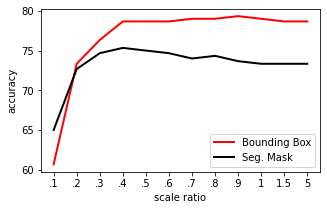

In [13]:
fig = plt.figure(figsize=[5, 3])

# plt.plot(seg_res_2*100, color='k', marker= '^', linewidth=2, markersize= 8)
# plt.plot(seg_res_8*100, color='k', marker= '^', linewidth=1, linestyle = '--', markersize= 8)


plt.plot(box_scale*100, color='r', linewidth=2)
plt.plot(seg_scale*100, color='k', linewidth=2)


plt.xlabel('scale ratio')
plt.ylabel('accuracy')
plt.xticks(np.arange(box_scale.shape[0]),['.1', '.2', '.3', '.4', '.5', '.6', '.7', '.8', '.9', '1', '1.5', 5])
plt.legend(['Bounding Box', 'Seg. Mask'])
plt.show()

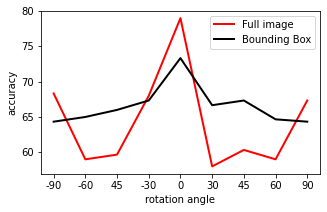

In [18]:
fig = plt.figure(figsize=[5, 3])
# plt.plot(full_rot*100, color='b', linewidth=2)
plt.plot(box_rot*100, color='r', linewidth=2)
plt.plot(seg_rot*100, color='k', linewidth=2)
plt.xlabel('rotation angle')
plt.ylabel('accuracy')
plt.xticks(np.arange(box_rot.shape[0]),['-90', '-60', '45', '-30', '0', '30', '45', '60', '90'])
plt.legend(['Full image', 'Bounding Box', 'Seg. Mask'])


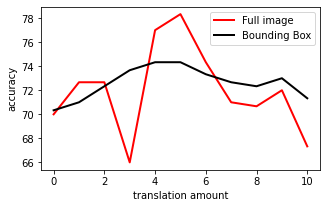

In [21]:
fig = plt.figure(figsize=[5, 3])
# plt.plot(full_trans*100, color='b', linewidth=2)
plt.plot(box_trans*100, color='r', linewidth=2)
plt.plot(seg_trans*100, color='k', linewidth=2)
plt.xlabel('translation amount')
plt.ylabel('accuracy')
# plt.xticks(np.arange(full_rot.shape[0]),['-90', '-60', '45', '-30', '0', '30', '45', '60', '90'])
plt.legend(['Full image', 'Bounding Box', 'Seg. Mask'])
plt.show()